## I. Data Treatment

### I.1. Imports

In [8]:
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm
from datetime import datetime

In [9]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re
nltk.download('vader_lexicon')
#from transformers import BertTokenizer, BertForSequenceClassification
#nltk.download('stopwords')
nltk.download('punkt')
import emoji
import string
from langdetect import detect, DetectorFactory
#from nltk.tokenize import word_tokenize
tqdm.pandas()
#from nltk.stem import PorterStemmer
#from nltk import pos_tag, ne_chunk
#from nltk.corpus import stopwords, wordnet
#from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/mehdimouden/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mehdimouden/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [10]:
tweets_raw = pd.read_csv('tweets.csv', sep=';', usecols=['timestamp','text','replies','likes','retweets', 'user', 'id'])
tweets_raw.head()

/var/folders/rh/41k8kg5x2js8n7lgg1fb7bj40000gn/T/ipykernel_83310/3947641556.py:1: DtypeWarning: Columns (0,1,4,8) have mixed types. Specify dtype option on import or set low_memory=False.
  tweets_raw = pd.read_csv('tweets.csv', sep=';', usecols=['timestamp','text','replies','likes','retweets', 'user', 'id'])


,id,user,timestamp,replies,likes,retweets,text
0,1132977055300300800,KamdemAbdiel,2019-05-27 11:49:14+00,0.0,0.0,0.0,È appena uscito un nuovo video! LES CRYPTOMONN...
1,1132977073402736640,bitcointe,2019-05-27 11:49:18+00,0.0,0.0,0.0,Cardano: Digitize Currencies; EOS https://t.co...
2,1132977023893139456,3eyedbran,2019-05-27 11:49:06+00,0.0,2.0,1.0,Another Test tweet that wasn't caught in the s...
3,1132977089089556481,DetroitCrypto,2019-05-27 11:49:22+00,0.0,0.0,0.0,Current Crypto Prices! \n\nBTC: $8721.99 USD\n...
4,1132977092340191232,mmursaleen72,2019-05-27 11:49:23+00,0.0,0.0,0.0,Spiv (Nosar Baz): BITCOIN Is An Asset &amp; NO...


In [11]:
tweets = tweets_raw[~((tweets_raw['likes'] == 0) & (tweets_raw['replies'] == 0) & (tweets_raw['retweets'] == 0))]
tweets['timestamp']=pd.to_datetime(tweets['timestamp'])

/var/folders/rh/41k8kg5x2js8n7lgg1fb7bj40000gn/T/ipykernel_83310/471161042.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets['timestamp']=pd.to_datetime(tweets['timestamp'])


In [12]:
tweets['Date']=tweets['timestamp']
tweets['Date'] = tweets['Date'].dt.date
tweets = tweets[tweets['Date'] >= pd.to_datetime('2016-11-01').date()]
tweets = tweets.sort_values(by='Date')
#tweets.set_index('Date', inplace=True)
tweets = tweets.dropna(subset=['text'])
print(len(tweets_raw), len(tweets))
tweets.head()

/var/folders/rh/41k8kg5x2js8n7lgg1fb7bj40000gn/T/ipykernel_83310/1391400100.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets['Date']=tweets['timestamp']
/var/folders/rh/41k8kg5x2js8n7lgg1fb7bj40000gn/T/ipykernel_83310/1391400100.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets['Date'] = tweets['Date'].dt.date


20165013 2544904


,id,user,timestamp,replies,likes,retweets,text,Date
2168782,793369330960502784,XTrade,2016-11-01 07:29:23+00:00,0.0,3.0,0.0,"Bitcoin climbs 3.2% today, reaching 720.00$ ea...",2016-11-01
2168726,793434374351917056,altcoinbonanza,2016-11-01 11:47:50+00:00,0.0,1.0,0.0,"Bitcoin once again on march to that $1,000 tar...",2016-11-01
2168720,793438944788615168,CryptoTweets99,2016-11-01 12:06:00+00:00,0.0,2.0,1.0,Re: Insane Giveaway! 12.00 INSANE for Supporte...,2016-11-01
2168719,793438950740361217,CryptoTweets99,2016-11-01 12:06:01+00:00,0.0,2.0,1.0,Re: Insane Giveaway! 12.00 INSANE for Supporte...,2016-11-01
2168715,793445007827070976,BTCticker,2016-11-01 12:30:06+00:00,0.0,0.0,1.0,One Bitcoin now worth $732.30@bitstamp. High $...,2016-11-01


In [13]:
tweets.to_csv('tweets_filter1.csv', sep=';',index=False)

In [7]:
tweets = pd.read_csv('tweets_filter1.csv', sep=';')

KeyboardInterrupt: 

In [ ]:
tweets.head()

### 1.2 Filter Spam

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
logistic_regression_classifier = LogisticRegression()
from sklearn.svm import SVC
svm_classifier = SVC()
from sklearn.ensemble import RandomForestClassifier
random_forest_classifier = RandomForestClassifier()
from sklearn.svm import SVC

In [44]:
#Export Sample to CSV to manually annotate spam
tweets_sample_spam = tweets['text'].head(3000).to_frame()
tweets_sample_spam.to_csv('sample_spam.csv', index=False)

In [15]:
# Load data (replace 'your_data.csv' with your file path)
marked_spam = pd.read_csv('marked_spam.csv', sep=';')
marked_spam = marked_spam.dropna(subset=['text'])
marked_spam['spam'] = marked_spam['spam'].fillna(0)
marked_spam.head(50)

,text,spam,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,"@John_Blocke There is no such thing as ""dividi...",0.0,NaN,NaN,NaN,NaN,NaN
1,$715.77 #bitfinex;\n$709.11 #GDAX;\n$700.78 #b...,1.0,NaN,NaN,NaN,NaN,NaN
2,One Bitcoin now worth $708.54@bitstamp. High $...,1.0,NaN,NaN,NaN,NaN,NaN
3,Current BUY price for 1 #bitcoin at Bitstocks ...,0.0,NaN,NaN,NaN,NaN,NaN
4,$728.40 #bitfinex;\n$709.00 #btce;\n$722.47 #G...,1.0,NaN,NaN,NaN,NaN,NaN
5,$730.42 #bitfinex;\n$712.00 #btce;\n$721.40 #G...,1.0,NaN,NaN,NaN,NaN,NaN
6,One Bitcoin now worth $720.00@bitstamp. High $...,1.0,NaN,NaN,NaN,NaN,NaN
7,"Bitcoin climbs 3.2% today, reaching 720.00$ ea...",0.0,NaN,NaN,NaN,NaN,NaN
8,Small paper #short around 659.00... #Bitcoin $...,0.0,NaN,NaN,NaN,NaN,NaN
9,$719.79 at 07:45 UTC [24h Range: $691.03 - $72...,1.0,NaN,NaN,NaN,NaN,NaN


In [16]:
#
X_spam = marked_spam['text']
Y_spam = marked_spam['spam']

X_train_spam, X_test_spam, Y_train_spam, Y_test_spam = train_test_split(X_spam, Y_spam, test_size=0.2, random_state=42)

tfidf_vectorizer = TfidfVectorizer(stop_words='english')
naive_bayes_classifier = MultinomialNB()
model_spam = Pipeline([
    ('vectorizer', tfidf_vectorizer),
    ('classifier', naive_bayes_classifier)
])
model_spam.fit(X_train_spam, Y_train_spam)
Y_pred_spam = model_spam.predict(X_test_spam)

print(f"Classification Report:\n{classification_report(Y_test_spam, Y_pred_spam)}")
print(f"Confusion Matrix:\n{confusion_matrix(Y_test_spam, Y_pred_spam)}")
print(f"Accuracy Score: {accuracy_score(Y_test_spam, Y_pred_spam)}")

Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.82      0.85       271
         1.0       0.86      0.90      0.88       329

    accuracy                           0.87       600
   macro avg       0.87      0.86      0.86       600
weighted avg       0.87      0.87      0.87       600

Confusion Matrix:
[[223  48]
 [ 32 297]]
Accuracy Score: 0.8666666666666667


In [17]:
##################### PREDICT IN TWEETS_ANALYSIS########################## 
tweets_spam = tweets.copy()

# Predict spam for the new data
predicted_spam = model_spam.predict(tweets['text'])

# Add predictions to the DataFrame
tweets_spam['spam'] = predicted_spam

In [18]:
tweets_spam.head()

,id,user,timestamp,replies,likes,retweets,text,Date,spam
2168782,793369330960502784,XTrade,2016-11-01 07:29:23+00:00,0.0,3.0,0.0,"Bitcoin climbs 3.2% today, reaching 720.00$ ea...",2016-11-01,1.0
2168726,793434374351917056,altcoinbonanza,2016-11-01 11:47:50+00:00,0.0,1.0,0.0,"Bitcoin once again on march to that $1,000 tar...",2016-11-01,0.0
2168720,793438944788615168,CryptoTweets99,2016-11-01 12:06:00+00:00,0.0,2.0,1.0,Re: Insane Giveaway! 12.00 INSANE for Supporte...,2016-11-01,1.0
2168719,793438950740361217,CryptoTweets99,2016-11-01 12:06:01+00:00,0.0,2.0,1.0,Re: Insane Giveaway! 12.00 INSANE for Supporte...,2016-11-01,1.0
2168715,793445007827070976,BTCticker,2016-11-01 12:30:06+00:00,0.0,0.0,1.0,One Bitcoin now worth $732.30@bitstamp. High $...,2016-11-01,1.0


In [19]:
tweets_spam.to_csv('tweets_filter1_spam_prediction.csv', sep=';', index=False)

In [23]:
print(/len(tweets_spam))

0.28611688299440763


In [80]:
print(len(tweets_spam)-sum(tweets_spam['spam']))

1816764.0


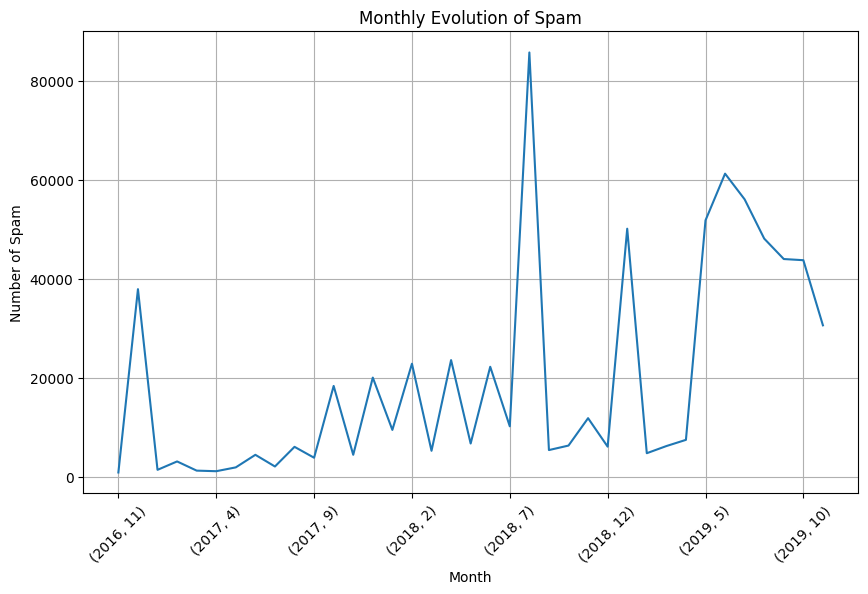

In [24]:
import matplotlib.pyplot as plt
# Group by year and month, and sum spam occurrences
monthly_spam = tweets_spam.groupby([tweets_spam['timestamp'].dt.year, tweets_spam['timestamp'].dt.month])['spam'].sum()
monthly_spam.plot(kind='line', figsize=(10, 6))

plt.title('Monthly Evolution of Spam')
plt.xlabel('Month')
plt.ylabel('Number of Spam')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.show()

### I.3. Pre-Processing & Spam Detection

In [25]:
# Set seed for language detection
DetectorFactory.seed = 0

# Regex patterns
url_pattern = re.compile(r"http\S+|www\S+|https\S+")
mention_pattern = re.compile(r'@[\w]+')  # Matches mentions
hashtag_pattern = re.compile(r'#([\w]+)')  # Matches hashtags but captures only the word

# Function to check if text is in English
def is_english(text):
    try:
        return detect(text) == 'en'
    except:
        return False
#Function to remove non-english from dataframe
def remove_non_english(text):
    if not is_english(text):
        return None

# Function to preprocess a single text entry
def preprocess_text(text):
    if not is_english(text):
        return None

    text = text.lower()
    text = url_pattern.sub('', text)
    text = mention_pattern.sub('', text)
    text = hashtag_pattern.sub(r'\1', text)
    text = emoji.demojize(text)
    #text = text.translate(str.maketrans('', '', string.punctuation))
    
    #text_tokens = word_tokenize(text)
    #return ' '.join(text_tokens)
    return text

In [26]:
tweets_spam.head()

,id,user,timestamp,replies,likes,retweets,text,Date,spam
2168782,793369330960502784,XTrade,2016-11-01 07:29:23+00:00,0.0,3.0,0.0,"Bitcoin climbs 3.2% today, reaching 720.00$ ea...",2016-11-01,1.0
2168726,793434374351917056,altcoinbonanza,2016-11-01 11:47:50+00:00,0.0,1.0,0.0,"Bitcoin once again on march to that $1,000 tar...",2016-11-01,0.0
2168720,793438944788615168,CryptoTweets99,2016-11-01 12:06:00+00:00,0.0,2.0,1.0,Re: Insane Giveaway! 12.00 INSANE for Supporte...,2016-11-01,1.0
2168719,793438950740361217,CryptoTweets99,2016-11-01 12:06:01+00:00,0.0,2.0,1.0,Re: Insane Giveaway! 12.00 INSANE for Supporte...,2016-11-01,1.0
2168715,793445007827070976,BTCticker,2016-11-01 12:30:06+00:00,0.0,0.0,1.0,One Bitcoin now worth $732.30@bitstamp. High $...,2016-11-01,1.0


In [27]:
tqdm.pandas()

tweets_spam_processed=tweets_spam.copy()
# Assuming 'preprocess_text' is your text processing function
# and 'df' is your DataFrame
tweets_spam_processed['text'] = tweets_spam_processed['text'].progress_apply(preprocess_text)
tweets_spam_processed.head()

python(86424) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
100%|██████████| 2544904/2544904 [4:00:58<00:00, 176.02it/s]  


,id,user,timestamp,replies,likes,retweets,text,Date,spam
2168782,793369330960502784,XTrade,2016-11-01 07:29:23+00:00,0.0,3.0,0.0,"bitcoin climbs 3.2% today, reaching 720.00$ ea...",2016-11-01,1.0
2168726,793434374351917056,altcoinbonanza,2016-11-01 11:47:50+00:00,0.0,1.0,0.0,"bitcoin once again on march to that $1,000 tar...",2016-11-01,0.0
2168720,793438944788615168,CryptoTweets99,2016-11-01 12:06:00+00:00,0.0,2.0,1.0,re: insane giveaway! 12.00 insane for supporte...,2016-11-01,1.0
2168719,793438950740361217,CryptoTweets99,2016-11-01 12:06:01+00:00,0.0,2.0,1.0,re: insane giveaway! 12.00 insane for supporte...,2016-11-01,1.0
2168715,793445007827070976,BTCticker,2016-11-01 12:30:06+00:00,0.0,0.0,1.0,one bitcoin now worth $732.30. high $737.00. l...,2016-11-01,1.0


In [28]:
tweets_spam_processed = tweets_spam_processed.dropna(subset=['text'])

In [30]:
tweets_spam_processed.head(10000)

,id,user,timestamp,replies,likes,retweets,text,Date,spam
2168782,793369330960502784,XTrade,2016-11-01 07:29:23+00:00,0.0,3.0,0.0,"bitcoin climbs 3.2% today, reaching 720.00$ ea...",2016-11-01,1.0
2168726,793434374351917056,altcoinbonanza,2016-11-01 11:47:50+00:00,0.0,1.0,0.0,"bitcoin once again on march to that $1,000 tar...",2016-11-01,0.0
2168720,793438944788615168,CryptoTweets99,2016-11-01 12:06:00+00:00,0.0,2.0,1.0,re: insane giveaway! 12.00 insane for supporte...,2016-11-01,1.0
2168719,793438950740361217,CryptoTweets99,2016-11-01 12:06:01+00:00,0.0,2.0,1.0,re: insane giveaway! 12.00 insane for supporte...,2016-11-01,1.0
2168715,793445007827070976,BTCticker,2016-11-01 12:30:06+00:00,0.0,0.0,1.0,one bitcoin now worth $732.30. high $737.00. l...,2016-11-01,1.0
...,...,...,...,...,...,...,...,...,...
2185285,815361993121103872,ThePriceOfBTC,2017-01-01 00:00:22+00:00,0.0,0.0,1.0,$967.00 bitfinex;\n$966.60 bitstamp;\n$970.36 ...,2017-01-01,1.0
16652423,816050976381685760,DanielKrawisz,2017-01-02 22:38:08+00:00,2.0,9.0,4.0,haha no seriously i would really like it if t...,2017-01-02,0.0
2186770,815731924618661889,ThePriceOfBTC,2017-01-02 00:30:21+00:00,0.0,0.0,1.0,$997.93 bitfinex;\n$997.80 bitstamp;\n$992.00 ...,2017-01-02,1.0
2186756,815746955452227588,coinok,2017-01-02 01:30:04+00:00,0.0,2.0,0.0,1 btc price: btc-e 962.998 usd bitstamp 998.50...,2017-01-02,1.0


In [29]:
def replace_words_in_dataframe(df, column_name):
    replacements = {
        ': fire :': 'trending',
        ': rocket :': 'trending',
        ': collision :': 'trending'
    }

    for word, replacement in replacements.items():
        df[column_name] = df[column_name].str.replace(r'\b' + word + r'\b', replacement, regex=True)
    
    return df

In [31]:
tweets_spam_processed = replace_words_in_dataframe(tweets_spam_processed, 'text')

In [33]:
tweets_spam_processed.to_csv('tweets_spam_processed.csv', sep=';', index=False) 

In [81]:
print(len(tweets_spam_processed))

1857838


In [5]:
### CHECKPOINT RELOADING ####

tweets_spam_processed=pd.read_csv('tweets_spam_processed.csv', sep=';')
tweets_spam_processed['timestamp'] = pd.to_datetime(tweets_processed['timestamp'])
tweets_spam_processed = tweets_processed.dropna(subset=['text'])
tweets_spam_processed.head(50)
##############################

,user,timestamp,replies,likes,retweets,text
0,btcusd,2016-12-31 03:00:37+00:00,0.0,1.0,1.0,95003 0400 utc 24h range 93100 96582 volume 11...
1,coinok,2016-12-31 04:17:03+00:00,0.0,1.0,0.0,order secure smart bitcoin hardware wallet 348...
2,coinok,2016-12-31 04:27:02+00:00,0.0,1.0,0.0,buy bitcoin paypal also cc paysafecard skrill ...
3,coinok,2016-12-31 04:30:04+00:00,0.0,1.0,0.0,1 btc price btce 924476 usd bitstamp 95068 usd...
4,ThePriceOfBTC,2016-12-31 04:30:25+00:00,0.0,0.0,1.0,95138 bitfinex 95068 bitstamp 95471 gdax 92448...
5,btcusd,2016-12-31 04:30:36+00:00,0.0,0.0,1.0,95068 0530 utc 24h range 93100 96582 volume 10...
6,coinok,2016-12-31 04:31:03+00:00,0.0,1.0,0.0,1 doge price bter 000000023 btc doge dogecoin ...
7,coinok,2016-12-31 04:42:02+00:00,0.0,1.0,0.0,hardware bitcoin wallet get trezor 99 btc bitc...
8,CryptoOz,2016-12-31 04:44:19+00:00,0.0,6.0,12.0,surely seeing pattern altcoin crypto bitcoin b...
9,dogecointicker,2016-12-31 05:00:01+00:00,0.0,1.0,0.0,current value doge btc vircurex 000000022 volu...


### I.4. Sentiment Analysis

In [34]:
# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()
# Create a function to apply VADER sentiment analysis and add sentiment scores to the DataFrame
def get_sentiment(text):
    sentiment = analyzer.polarity_scores(text)
    return sentiment
# Create a function to calculate weights for each tweet
def calculate_weights(tweet):
    weight = tweet['likes'] + tweet['retweets'] + tweet['replies']
    return weight #if weight > 0 else 1  # Ensure a non-zero minimum weight
# Create a function to calculate weighted average sentiment
def weighted_average(group):
    weighted_sentiments = group['compound_sentiment'] * group['weight']
    return weighted_sentiments.sum() / group['weight'].sum()

In [ ]:
# Apply the sentiment analysis function to the preprocessed 'text' column
#tweets_analysis=tweets_processed.copy()
#tweets_analysis['sentiment'] = tweets_analysis['text'].apply(get_sentiment)
#tweets_analysis['compound_sentiment'] = tweets_analysis['sentiment'].apply(lambda x: x['compound'])
#tweets_analysis.head()
#tweets_analysis.to_csv('vador.csv', index=False)
#tweets_sample_spam = tweets_analysis['text'].tail(10000).to_frame()
#tweets_sample_spam.to_csv('sampled_spam.csv', index=False)
#tweets_analysis_sorted = tweets_analysis.sort_values(by='compound_sentiment', ascending=True)
#tweets_analysis_sorted.head(50)

In [35]:
tweets_analysis=tweets_spam_processed.copy()

In [36]:
tweets_analysis=tweets_analysis[tweets_analysis['spam']==0.0]
print(len(tweets_analysis))
tweets_analysis.head()

1463548


,id,user,timestamp,replies,likes,retweets,text,Date,spam
2168726,793434374351917056,altcoinbonanza,2016-11-01 11:47:50+00:00,0.0,1.0,0.0,"bitcoin once again on march to that $1,000 tar...",2016-11-01,0.0
16717835,793242715026841601,rogerkver,2016-11-01 00:06:15+00:00,37.0,100.0,37.0,"we who love bitcoin, are embarrassed by the to...",2016-11-01,0.0
11789870,793463767053037568,bitcoincoreorg,2016-11-01 14:44:38+00:00,0.0,23.0,25.0,"psa: the bitcoin ""network wide alert system"" i...",2016-11-01,0.0
2168826,793312119844286468,coinok,2016-11-01 03:42:03+00:00,0.0,1.0,1.0,the hardware bitcoin wallet. get trezor now fo...,2016-11-01,0.0
2168783,793364164379041792,khunFYP,2016-11-01 07:08:51+00:00,1.0,0.0,0.0,small paper short around 659.00... bitcoin $bt...,2016-11-01,0.0


In [38]:
tweets_analysis['sentiment'] = tweets_analysis['text'].progress_apply(get_sentiment)
tweets_analysis['compound_sentiment'] = tweets_analysis['sentiment'].apply(lambda x: x['compound'])
tweets_analysis.head()

100%|██████████| 1463548/1463548 [07:20<00:00, 3325.95it/s]


,id,user,timestamp,replies,likes,retweets,text,Date,spam,sentiment,compound_sentiment
2168726,793434374351917056,altcoinbonanza,2016-11-01 11:47:50+00:00,0.0,1.0,0.0,"bitcoin once again on march to that $1,000 tar...",2016-11-01,0.0,"{'neg': 0.0, 'neu': 0.826, 'pos': 0.174, 'comp...",0.5859
16717835,793242715026841601,rogerkver,2016-11-01 00:06:15+00:00,37.0,100.0,37.0,"we who love bitcoin, are embarrassed by the to...",2016-11-01,0.0,"{'neg': 0.297, 'neu': 0.455, 'pos': 0.248, 'co...",-0.1027
11789870,793463767053037568,bitcoincoreorg,2016-11-01 14:44:38+00:00,0.0,23.0,25.0,"psa: the bitcoin ""network wide alert system"" i...",2016-11-01,0.0,"{'neg': 0.0, 'neu': 0.804, 'pos': 0.196, 'comp...",0.2960
2168826,793312119844286468,coinok,2016-11-01 03:42:03+00:00,0.0,1.0,1.0,the hardware bitcoin wallet. get trezor now fo...,2016-11-01,0.0,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
2168783,793364164379041792,khunFYP,2016-11-01 07:08:51+00:00,1.0,0.0,0.0,small paper short around 659.00... bitcoin $bt...,2016-11-01,0.0,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000


In [39]:
tweets_analysis.to_csv('tweets_analysis.csv', sep=';' , index=False)

In [ ]:
### CHECKPOINT RELOADING ####
tweets_analysis=pd.read_csv('tweets_analysis.csv', sep=';')

In [40]:
tweets_analysis_sorted = tweets_analysis.sort_values(by='compound_sentiment', ascending=False)
tweets_analysis_sorted.head(50)

,id,user,timestamp,replies,likes,retweets,text,Date,spam,sentiment,compound_sentiment
17144858,1179997121145196544,johnkim77,2019-10-04 05:50:11+00:00,4.0,53.0,8.0,i like bitcoin. \n\ni love litecoin.\n\ni like...,2019-10-04,0.0,"{'neg': 0.0, 'neu': 0.231, 'pos': 0.769, 'comp...",0.9953
16349728,1175415755665477632,brandonlharris,2019-09-21 14:25:28+00:00,4.0,6.0,3.0,i'll giveaway $25 via cashapp or\n$25 worth of...,2019-09-21,0.0,"{'neg': 0.0, 'neu': 0.371, 'pos': 0.629, 'comp...",0.9947
14270941,1164661460494159872,burka24,2019-08-22 22:11:45+00:00,0.0,0.0,1.0,play game earn free btc --- play game earn fre...,2019-08-22,0.0,"{'neg': 0.0, 'neu': 0.403, 'pos': 0.597, 'comp...",0.9927
15161146,1169077961443684353,MelissaHoughto6,2019-09-04 02:41:21+00:00,0.0,1.0,1.0,"i can't give you money, but i can respect you ...",2019-09-04,0.0,"{'neg': 0.0, 'neu': 0.436, 'pos': 0.564, 'comp...",0.9920
12495707,1155176530110287873,silvertooth6876,2019-07-27 18:02:01+00:00,1.0,13.0,4.0,bravo:clapping_hands:...... i won the free tic...,2019-07-27,0.0,"{'neg': 0.0, 'neu': 0.478, 'pos': 0.522, 'comp...",0.9919
5477297,1024583894320832512,elypratama,2018-08-01 07:13:30+00:00,0.0,3.0,0.0,it’s new but it’s valuable. everybody must be ...,2018-08-01,0.0,"{'neg': 0.0, 'neu': 0.408, 'pos': 0.592, 'comp...",0.9916
11158003,1149414925967745024,MrsPamela4,2019-07-11 20:27:28+00:00,0.0,1.0,1.0,"binary options is real, i have made more than ...",2019-07-11,0.0,"{'neg': 0.026, 'neu': 0.471, 'pos': 0.504, 'co...",0.9915
8251273,1051907007173849090,braincramps,2018-10-15 18:45:48+00:00,0.0,1.0,1.0,bitcoin=freedom\nfreedom from fiat\nfreedom to...,2018-10-15,0.0,"{'neg': 0.0, 'neu': 0.426, 'pos': 0.574, 'comp...",0.9911
9683121,1143455986100785152,cryptoqueeny,2019-06-25 09:48:46+00:00,0.0,1.0,1.0,it is like tronbet but it is giving huge re...,2019-06-25,0.0,"{'neg': 0.0, 'neu': 0.319, 'pos': 0.681, 'comp...",0.9909
13817897,1162173497143189504,Raina_Crypto,2019-08-16 01:25:28+00:00,0.0,1.0,1.0,thanks for mentioning on the podcast inter...,2019-08-16,0.0,"{'neg': 0.0, 'neu': 0.321, 'pos': 0.679, 'comp...",0.9907


In [41]:
tweets_analysis_sorted.tail(50)

,id,user,timestamp,replies,likes,retweets,text,Date,spam,sentiment,compound_sentiment
7230696,1133645082081538048,mademoisellesav,2019-05-29 08:03:44+00:00,0.0,0.0,1.0,tokenpayscam his is a scam project. all fake ...,2019-05-29,0.0,"{'neg': 0.537, 'neu': 0.463, 'pos': 0.0, 'comp...",-0.9817
7216694,1133646993195196418,mademoisellesav,2019-05-29 08:11:19+00:00,0.0,0.0,1.0,tokenpayscam his is a scam project. all fake ...,2019-05-29,0.0,"{'neg': 0.537, 'neu': 0.463, 'pos': 0.0, 'comp...",-0.9817
7230884,1133644369112776705,mademoisellesav,2019-05-29 08:00:54+00:00,0.0,0.0,1.0,tokenpayscam his is a scam project. all fake...,2019-05-29,0.0,"{'neg': 0.537, 'neu': 0.463, 'pos': 0.0, 'comp...",-0.9817
10869067,1148348392055201793,dn2k,2019-07-08 21:49:26+00:00,0.0,6.0,1.0,"bitcoin, last 10yrs:\n\n- no fines\n- no offen...",2019-07-08,0.0,"{'neg': 0.604, 'neu': 0.305, 'pos': 0.091, 'co...",-0.9817
616107,1129077280540712962,mademoisellesav,2019-05-16 15:32:55+00:00,0.0,0.0,1.0,tokenpayscam his is a scam project. all fake ...,2019-05-16,0.0,"{'neg': 0.537, 'neu': 0.463, 'pos': 0.0, 'comp...",-0.9817
12288114,1154762287934128130,Nonfiction8879,2019-07-26 14:35:58+00:00,1.0,5.0,1.0,$tsla = fake cars \n$bynd = fake meat \n$btc =...,2019-07-26,0.0,"{'neg': 0.612, 'neu': 0.388, 'pos': 0.0, 'comp...",-0.9818
8400354,1139698362087878656,mikerelentless,2019-06-15 00:57:18+00:00,2.0,6.0,2.0,fuck segwit.\n\nfuck rbf.\n\nfuck lazy cunts ...,2019-06-15,0.0,"{'neg': 0.518, 'neu': 0.44, 'pos': 0.042, 'com...",-0.9819
18178112,1186487136867901445,MiguelCuneta,2019-10-22 03:39:11+00:00,3.0,15.0,1.0,organized religion is historically the worst i...,2019-10-22,0.0,"{'neg': 0.45, 'neu': 0.528, 'pos': 0.022, 'com...",-0.9819
16364972,1175509825700028416,bascule,2019-09-21 20:39:17+00:00,9.0,37.0,5.0,"bitcoin maximalists love to say this, but it's...",2019-09-21,0.0,"{'neg': 0.463, 'neu': 0.475, 'pos': 0.062, 'co...",-0.9820
5421691,1024990318842847233,cryptogmoe,2018-08-02 10:08:30+00:00,1.0,7.0,2.0,the only thing pissing me off today is that $b...,2018-08-02,0.0,"{'neg': 0.463, 'neu': 0.537, 'pos': 0.0, 'comp...",-0.9821


In [44]:
tweets_analysis[tweets_analysis.duplicated(subset=['user', 'text', 'Date'], keep='first')].head(10000)

,id,user,timestamp,replies,likes,retweets,text,Date,spam,sentiment,compound_sentiment
2174193,802822273988259840,freebitcointalk,2016-11-27 09:32:00+00:00,0.0,2.0,1.0,stocks java game development framework value $...,2016-11-27,0.0,"{'neg': 0.0, 'neu': 0.769, 'pos': 0.231, 'comp...",0.3400
3432903,810286590656249856,AltcoinsBank,2016-12-17 23:52:32+00:00,0.0,2.0,0.0,re: will a nation ever fully adopt bitcoin? ...,2016-12-17,0.0,"{'neg': 0.0, 'neu': 0.819, 'pos': 0.181, 'comp...",0.2484
3439898,810115870739533828,freebitcointalk,2016-12-17 12:34:09+00:00,0.0,1.0,1.0,prohibition 2048 bitcoin btcb0t,2016-12-17,0.0,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
3440699,810099872833617921,bitcoinpoet,2016-12-17 11:30:35+00:00,0.0,2.0,1.0,venezuelans are buying bitcoin to purchase bas...,2016-12-17,0.0,"{'neg': 0.273, 'neu': 0.559, 'pos': 0.168, 'co...",-0.4019
3440628,810082626627203072,AltcoinsBank,2016-12-17 10:22:03+00:00,0.0,1.0,1.0,re: bitcoin atm bitcoin_discussion bitcoin b...,2016-12-17,0.0,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
...,...,...,...,...,...,...,...,...,...,...,...
3993409,918068971177377792,mog7546,2017-10-11 09:01:14+00:00,0.0,3.0,3.0,putin tells central bank not to create barrie...,2017-10-11,0.0,"{'neg': 0.168, 'neu': 0.832, 'pos': 0.0, 'comp...",-0.2057
3993407,918068971177377792,mog7546,2017-10-11 09:01:14+00:00,0.0,3.0,3.0,putin tells central bank not to create barrie...,2017-10-11,0.0,"{'neg': 0.168, 'neu': 0.832, 'pos': 0.0, 'comp...",-0.2057
3993405,918068971177377792,mog7546,2017-10-11 09:01:14+00:00,0.0,3.0,3.0,putin tells central bank not to create barrie...,2017-10-11,0.0,"{'neg': 0.168, 'neu': 0.832, 'pos': 0.0, 'comp...",-0.2057
3993403,918068971177377792,mog7546,2017-10-11 09:01:14+00:00,0.0,3.0,3.0,putin tells central bank not to create barrie...,2017-10-11,0.0,"{'neg': 0.168, 'neu': 0.832, 'pos': 0.0, 'comp...",-0.2057


In [46]:
#We drop the duplicates by the same users the same day, this might be noise
tweets_analysis = tweets_analysis.drop_duplicates(subset=['text', 'user', 'Date'], keep='first')

In [48]:
tweets_analysis.to_csv('tweets_analysis.csv', sep=';', index=False)

In [ ]:
### CHECKPOINT RELOADING ####
tweets_analysis = pd.read_csv('tweets_analysis.csv', sep=';')

In [55]:
# Step 1: Calculate weights for each tweet
tweets_analysis['weight'] = tweets_analysis.apply(calculate_weights, axis=1)

# Step 2 and 3: Group by Date and calculate weighted average sentiment
grouped = tweets_analysis.groupby('Date')
tweets_analysis_daily = grouped.apply(lambda x: weighted_average(x)).reset_index(name='Weighted_Average_Sentiment')

# Step 4: Count the Number of Tweets per Day
tweets_analysis_daily['Daily_Volume'] = grouped.size().values

# Result
tweets_analysis_daily.head()

,Date,Weighted_Average_Sentiment,Daily_Volume
0,2016-11-01,-0.018521,6
1,2016-11-02,-0.179474,7
2,2016-11-03,0.391692,3
3,2016-11-04,-0.241694,4
4,2016-11-05,0.492600,1


In [60]:
tweets_analysis_daily['Weighted_Average_Sentiment_Change'] = tweets_analysis_daily['Weighted_Average_Sentiment'].diff()
tweets_analysis_daily['Daily_Volume_Change'] = tweets_analysis_daily['Daily_Volume'].pct_change()
tweets_analysis_daily=tweets_analysis_daily.dropna(subset=['Daily_Volume_Change'])
tweets_analysis_daily.head()

,Date,Weighted_Average_Sentiment,Daily_Volume,Weighted_Average_Sentiment_Change,Daily_Volume_Change
0,2016-11-01,-0.018521,6,NaN,NaN
1,2016-11-02,-0.179474,7,-0.160952,0.166667
2,2016-11-03,0.391692,3,0.571165,-0.571429
3,2016-11-04,-0.241694,4,-0.633386,0.333333
4,2016-11-05,0.492600,1,0.734294,-0.750000


In [62]:
tweets_analysis_daily.to_csv('tweets_analysis_daily.csv', sep=';', index=False)

In [69]:
tweets_analysis_daily_copy = tweets_analysis_daily.copy()

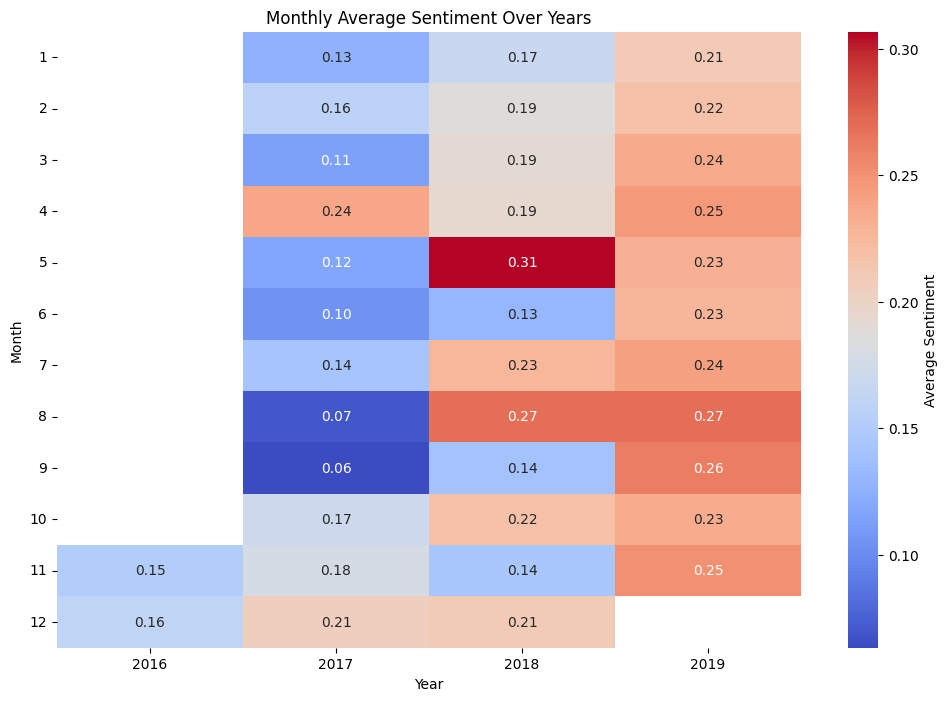

In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your dataframe is named df
# Convert 'Date' column to datetime if not already
tweets_analysis_daily_copy['Date'] = pd.to_datetime(tweets_analysis_daily_copy['Date'])

# Extract year and month
tweets_analysis_daily_copy['Year'] = tweets_analysis_daily_copy['Date'].dt.year
tweets_analysis_daily_copy['Month'] = tweets_analysis_daily_copy['Date'].dt.month

# Group by year and month and calculate mean sentiment
monthly_avg_sentiment = tweets_analysis_daily_copy.groupby(['Year', 'Month'])['Weighted_Average_Sentiment'].mean().reset_index()

# Pivot the dataframe for easy plotting
pivot_df = monthly_avg_sentiment.pivot_table(index='Month', columns='Year', values='Weighted_Average_Sentiment')

# Plotting
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_df, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'Average Sentiment'})
plt.title('Monthly Average Sentiment Over Years')
plt.xlabel('Year')
plt.ylabel('Month')
plt.yticks(rotation=0)  # Keep the month labels horizontal
plt.show()

/var/folders/rh/41k8kg5x2js8n7lgg1fb7bj40000gn/T/ipykernel_83310/4098843518.py:26: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  bitcoin_df['Month-Year'] = bitcoin_df['Date'].dt.to_period('M')


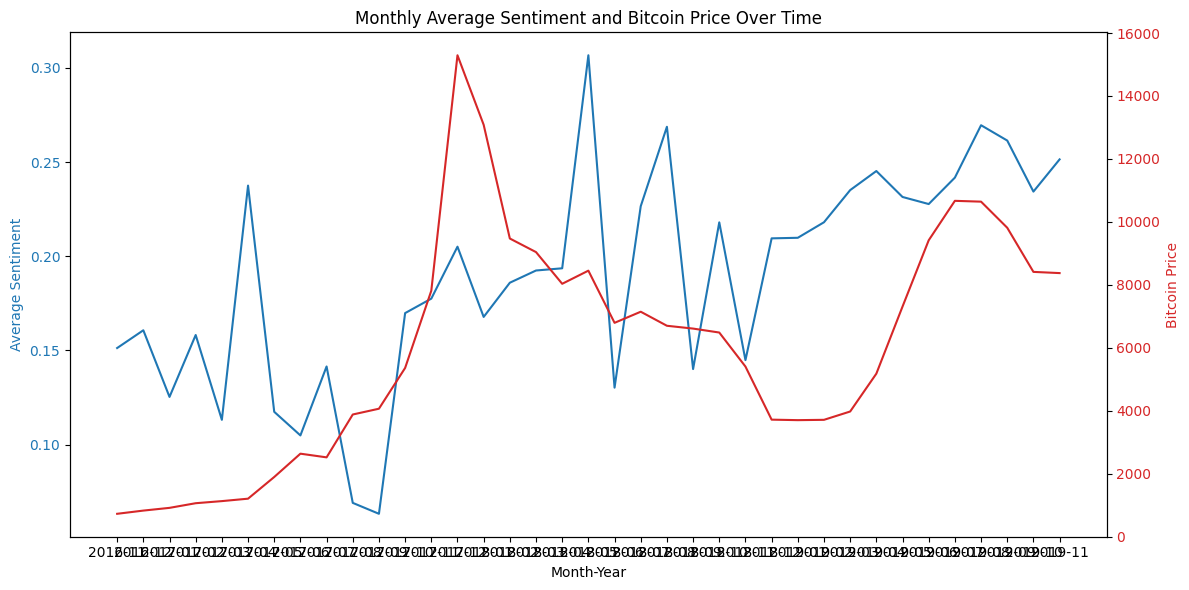

In [78]:
import yfinance as yf

# Define the date range for which you want to fetch historical data
start_date = "2016-11-01"
end_date = "2019-12-01"
df=tweets_analysis_daily.copy()
bitcoin_df = yf.Ticker("BTC-USD").history(start=start_date, end=end_date)

# Assuming df is your sentiment dataframe
# Convert 'Date' column to datetime if not already
df['Date'] = pd.to_datetime(df['Date'])

# Calculate monthly average sentiment
df['Month-Year'] = df['Date'].dt.to_period('M')
monthly_avg_sentiment = df.groupby('Month-Year')['Weighted_Average_Sentiment'].mean().reset_index()

# Assuming bitcoin_df is your Bitcoin price dataframe
# Convert 'Month-Year' to string for plotting
monthly_avg_sentiment['Month-Year'] = monthly_avg_sentiment['Month-Year'].astype(str)

# Load your Bitcoin price data into a DataFrame
# bitcoin_df should have columns 'Date' and 'Price'
# bitcoin_df = pd.read_csv('bitcoin_price.csv')
bitcoin_df['Date'] = bitcoin_df.index
bitcoin_df['Date'] = pd.to_datetime(bitcoin_df['Date'])
bitcoin_df['Month-Year'] = bitcoin_df['Date'].dt.to_period('M')
bitcoin_df['Month-Year'] = bitcoin_df['Month-Year'].astype(str)

# Calculate monthly average Bitcoin price
monthly_avg_bitcoin_price = bitcoin_df.groupby('Month-Year')['Close'].mean().reset_index()

# Merge the two dataframes on 'Month-Year'
merged_df = pd.merge(monthly_avg_sentiment, monthly_avg_bitcoin_price, on='Month-Year', how='outer')

# Sort by 'Month-Year'
merged_df.sort_values(by='Month-Year', inplace=True)

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Sentiment plot
ax1.set_xlabel('Month-Year')
ax1.set_ylabel('Average Sentiment', color='tab:blue')
ax1.plot(merged_df['Month-Year'], merged_df['Weighted_Average_Sentiment'], color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Bitcoin price plot
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Bitcoin Price', color='tab:red') 
ax2.plot(merged_df['Month-Year'], merged_df['Close'], color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title('Monthly Average Sentiment and Bitcoin Price Over Time')
fig.tight_layout()  # To ensure there's no layout overlap
plt.xticks(rotation=45)  # Rotate x-labels for better readability
plt.show()


In [ ]:
tweets_analysis_nospam.head()